In [ ]:
# %pip install tensorflow-addons==0.11.2

In [2]:
%pip install tensorflow-gpu==2.3.0
# if you are using cpu, just install tensorflow==2.2.0

     |████████████████████████████████| 320.4 MB 51 kB/s 
     |████████████████████████████████| 20.1 MB 1.4 MB/s 
     |████████████████████████████████| 459 kB 62.1 MB/s 
     |████████████████████████████████| 5.8 MB 60.0 MB/s 
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.6
    Uninstalling numpy-1.21.6:
      Successfully uninstalled numpy-1.21.6
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.2.0
    Uninstalling tensorflow-estimator-2.2.0:
      Successfully uninstalled tensorflow-estimator-2.2.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.2.2
    Uninstalling tensorboard-2.2.2:
      Successfully uninstalled tensorboard-2.2.2
  Attempting uninstall: tensorflow-gpu
    Found existing installation: tensorflow-gpu 2.2.0
    Uninstalling tensorflow-gpu-2.2.0:
      Successfully uninstalled tensorflow-gpu-2.2.0
ERROR: pip's dependency resolver does not currently t

In [1]:
import matplotlib as mpl
import tensorflow as tf
import tensorflow_addons as tfa
import os
import time
import datetime
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers as layers

In [2]:
# params
CLASSES_NUM = 6  # 输出6类地物
LABELS = ['', 'Trees', 'Asphalt', 'Parking lot', 'Bitumen', 'Meadow', 'Soil']
VAL_FRAC = 0.5
TEST_FRAC = 0.3  # target用来测试数据的百分比 test/train
TRAIN_FRAC = 0.7
mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False
BUFFER_SIZE = 60000
BATCH_SIZE = 70
LAMBDA = 100
BANDS = 72
EPOCHS = 1000
PATIENCE = 15
noise_dim = 72
num_examples_to_generate = 16
seed = tf.random.normal([BATCH_SIZE, 72, 1])
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
FEATURE_dim = 36
lr = 1e-4 * 4

In [3]:
# utils
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)


def gen_dataset_from_dict(file_dict, Val=False):
    data = file_dict['data']
    data = np.transpose(data, (0, 2, 1))
    label = file_dict['gt']
    data_train, data_test, label_train, label_test = train_test_split(data, label, test_size=TEST_FRAC, random_state=42)
    if Val:
        data_test, data_val, label_test, label_val = train_test_split(data_test, label_test, test_size=VAL_FRAC,
                                                                      random_state=43)
    data_train = tf.data.Dataset.from_tensor_slices(data_train)
    data_test = tf.data.Dataset.from_tensor_slices(data_test)
    label_train = tf.data.Dataset.from_tensor_slices(label_train)
    label_test = tf.data.Dataset.from_tensor_slices(label_test)
    if Val:
        data_val = tf.data.Dataset.from_tensor_slices(data_val)
        label_val = tf.data.Dataset.from_tensor_slices(label_val)
        val_ds = tf.data.Dataset.zip((data_val, label_val))
        val_ds = val_ds.map(lambda x, y: {'data': x, 'label': y}).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

    train_ds = tf.data.Dataset.zip((data_train, label_train))
    test_ds = tf.data.Dataset.zip((data_test, label_test))

    train_ds = train_ds.map(lambda x, y: {'data': x, 'label': y}).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
    test_ds = test_ds.map(lambda x, y: {'data': x, 'label': y}).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
    if Val:
        return train_ds, test_ds, val_ds
    else:
        return train_ds, test_ds


def generate_and_save_Images(model, epoch, test_input):
    """Notice `training` is set to False.
       This is so all layers run in inference mode (batch norm)."""
    """To-do: reshape the curves as they were normalized"""
    prediction = model(test_input, training=False)
    plt.plot(np.arange(72), prediction[0, :, 0])
    plt.savefig('./pics/image_at_{:04d}_epoch.png'.format(epoch))
    plt.show()


def get_data_from_batch(batches):
    return batches['data'], batches['label']


def calculate_acc(target_test_ds,
                  classifier,
                  epoch):
    target_batch = target_test_ds.shuffle(BUFFER_SIZE).as_numpy_iterator().next()
    target_data, target_label = get_data_from_batch(target_batch)
    prediction_t = classifier(target_data, training=False)
    accuracy_t = tf.metrics.Accuracy(target_label, prediction_t)
    acc = accuracy_t.result()
    accuracy_t.update_state(y_true=target_label,
                            y_pred=prediction_t)
    print('Target accuracy for epoch {} is'.format(epoch + 1),
          '{}%'.format(accuracy_t.result().numpy() * 100))
    return acc


def plot_acc_loss(acc, gen_loss, disc_loss, cls_loss,
                  generator_loss, discriminator_loss, classifier_loss,
                  source_test_ds, target_test_ds,
                  generator, discriminator, classifier,
                  epoch):
    g_loss, d_loss, c_loss, a = [], [], [], []
    for source_test_batch in source_test_ds.as_numpy_iterator():
        for target_test_batch in target_test_ds.as_numpy_iterator():
            X_s, Y_s = get_data_from_batch(source_test_batch)
            X_t, Y_t = get_data_from_batch(target_test_batch)
            generated_target = generator(X_s, training=False)
            real_decision = discriminator(X_t, training=False)
            fake_decision = discriminator(generated_target, training=False)
            prediction = classifier(X_t, training=False)
            accuracy_t = tf.metrics.Accuracy()
            accuracy_t.update_state(y_true=Y_t,
                                    y_pred=prediction)
            a.append(accuracy_t.result().numpy())
            c_loss.append(classifier_loss(prediction, Y_t).numpy())
            g_loss.append(generator_loss(fake_decision).numpy())
            d_loss.append(discriminator_loss(real_decision, fake_decision).numpy())
    a = np.average(a)
    acc.append(a)
    cls_loss.append(np.average(c_loss))
    gen_loss.append(np.average(g_loss))
    disc_loss.append(np.average(d_loss))
    epochs_range = range(epoch+1)

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, gen_loss, label='Generator_loss')
    plt.plot(epochs_range, disc_loss, label='Discriminator_loss')
    plt.plot(epochs_range, cls_loss, label='Classifier_loss')
    plt.legend(loc='lower right')
    plt.title('Generator and discriminator loss')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, acc, label='Test accuracy')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()
    return acc, gen_loss, disc_loss, cls_loss

In [4]:
# Resnet
class ResBlock_up_top(tf.keras.layers.Layer):
    def __init__(self, output_channels):
        super().__init__()
        self.bn = layers.BatchNormalization()
        self.unsampling = layers.UpSampling1D()
        self.conv = tfa.layers.SpectralNormalization(layers.Conv1D(filters=output_channels,
                                                                   kernel_size=3,
                                                                   strides=1,
                                                                   padding='same',
                                                                   use_bias=False))
        self.conv_skip = tfa.layers.SpectralNormalization(layers.Conv1D(filters=output_channels,
                                                                        kernel_size=1,
                                                                        strides=1,
                                                                        padding='same',
                                                                        use_bias=False))
        self.relu = layers.LeakyReLU()

    def __call__(self, inputs):
        res = inputs
        res = self.unsampling(res)
        res = self.conv_skip(res)

        x = self.bn(inputs)
        x = self.relu(x)
        x = self.unsampling(x)
        x = self.conv_skip(x)
        x = self.relu(x)
        x = self.conv(x)

        return x + res


class ResBlock(tf.keras.layers.Layer):
    def __init__(self, output_channels):
        super().__init__()
        self.Conv = tfa.layers.SpectralNormalization(layers.Conv1D(filters=output_channels,
                                                                   kernel_size=3,
                                                                   strides=1,
                                                                   padding='same',
                                                                   use_bias=False))
        self.Relu = layers.LeakyReLU()

    def __call__(self, inputs):
        res = inputs
        x = self.Conv(inputs)
        x = self.Relu(x)
        x = self.Conv(x)
        x = x + res
        return x


class ResBlock_up(tf.keras.layers.Layer):
    def __init__(self, output_channels, **kwargs):
        super().__init__(**kwargs)
        self.bn = layers.BatchNormalization()
        self.relu = layers.LeakyReLU()
        self.unsampling = layers.UpSampling1D()
        self.conv = tfa.layers.SpectralNormalization(layers.Conv1D(filters=output_channels,
                                                                   kernel_size=3,
                                                                   strides=1,
                                                                   padding='same',
                                                                   use_bias=False))
        self.conv_skip = tfa.layers.SpectralNormalization(layers.Conv1D(filters=output_channels,
                                                                        kernel_size=1,
                                                                        padding='same',
                                                                        use_bias=False))

    def __call__(self, inputs):
        res = inputs
        res = self.unsampling(res)
        res = self.conv_skip(res)
        x = self.bn(inputs)
        x = self.relu(x)
        x = self.unsampling(x)
        x = self.conv_skip(x)
        x = self.relu(x)
        x = self.conv(x)
        return x + res


class ResBlock_Down(tf.keras.layers.Layer):
    def __init__(self, output_channels):
        super().__init__()
        self.relu = layers.LeakyReLU()
        self.conv = tfa.layers.SpectralNormalization(layers.Conv1D(filters=output_channels,
                                                                   kernel_size=3,
                                                                   padding='same',
                                                                   use_bias=False))
        self.conv_skip = tfa.layers.SpectralNormalization(layers.Conv1D(filters=output_channels,
                                                                        kernel_size=1,
                                                                        padding='same',
                                                                        use_bias=False))
        self.avg_pooling = layers.AveragePooling1D(padding='same')

    def __call__(self, inputs):
        res = self.conv_skip(inputs)
        res = self.avg_pooling(res)

        x = self.relu(inputs)
        x = self.conv_skip(x)
        x = self.relu(x)
        x = self.conv(x)
        x = self.avg_pooling(x)

        return x + res


class Res_Dense(tf.keras.layers.Layer):
    def __init__(self, units):
        super().__init__()
        self.dense = tfa.layers.SpectralNormalization(layers.Dense(units))
        self.drop = layers.Dropout(0.3)
        self.relu = layers.LeakyReLU()

    def __call__(self, inputs):
        res = inputs
        res = self.dense(res)
        res = self.relu(res)

        x = self.dense(inputs)
        x = self.drop(x)
        x = self.relu(x)

        return x + res


class bottle_neck(tf.keras.layers.Layer):
    def __init__(self, output_channels):
        super().__init__()
        self.filters = output_channels
        self.bn = layers.BatchNormalization()
        self.conv = layers.Conv1D(filters=output_channels,
                                  kernel_size=3,
                                  padding='same',
                                  use_bias=False)
        self.conv_skip = layers.Conv1D(filters=output_channels,
                                       kernel_size=1,
                                       strides=1,
                                       padding='same',
                                       use_bias=False)
        self.conv_trans = layers.Conv1D(filters=output_channels,
                                                 kernel_size=1,
                                                 strides=1,
                                                 padding='same',
                                                 use_bias=False)
        self.unsampling = layers.UpSampling1D()
        self.relu = layers.LeakyReLU()

    def __call__(self, inputs):
        if self.filters != inputs.get_shape().as_list()[-1]:
            res = self.conv_skip(inputs)
        else:
            res = inputs
        x = self.conv(inputs)
        x = self.bn(x)
        x = self.relu(x)
        x = self.conv_trans(x)
        x = self.bn(x)
        x = self.relu(x)
        z = x + res

        return x + res


class bottleneck_rev_s(layers.Layer):
    def __init__(self, channels):
        super().__init__()
        self.filters = channels
        self.unit = bottle_neck(int(channels//2.0))
        self.dense = layers.Dense(int(channels//2.0))

    def __call__(self, inputs):
        x1, x2 = tf.split(inputs, 2, 2)
        if self.filters != inputs.get_shape().as_list()[-1]:
            x1 = self.dense(x1)
        y1 = x1 + self.unit(x2)
        y2 = x2
        z = tf.concat([y2, y1], axis=2)
        return z


class ResBlock_no_sn(layers.Layer):
    def __init__(self, units):
        super().__init__()
        self.dense1 = layers.Dense(units)
        self.dense2 = layers.Dense(units)
        self.dropout = layers.Dropout(0.3)
        self.relu = layers.LeakyReLU()

    def __call__(self, inputs):
        res = self.dense1(inputs)
        res = self.relu(res)

        x = self.dense1(inputs)
        x = self.dropout(x)
        x = self.relu(x)
        x = self.dense2(x)
        x = self.dropout(x)
        x = self.relu(x)
        return x+res

In [5]:
# Model
def down_sample(filters, size, apply_bn=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(
        tf.keras.layers.Conv1D(filters, size, strides=1, padding='same',
                               kernel_initializer=initializer, use_bias=False))
    if apply_bn:
        result.add(tfa.layers.InstanceNormalization())
    result.add(tf.keras.layers.LeakyReLU())
    return result


def up_sample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(
        tf.keras.layers.Conv1D(filters, size, strides=1,
                               padding='same',
                               kernel_initializer=initializer,
                               use_bias=False))

    result.add(tfa.layers.InstanceNormalization())

    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))

    result.add(tf.keras.layers.ReLU())

    return result


def make_classifier_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(FEATURE_dim * 2, input_shape=(72, 1)))
    model.add(ResBlock_up_top(FEATURE_dim))
    model.add(layers.Dropout(0.2))
    model.add(layers.BatchNormalization())
    model.add(ResBlock_up(FEATURE_dim))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(CLASSES_NUM, activation='relu'))
    model.add(layers.Dropout(0.2))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Flatten())
    model.add(layers.Dense(CLASSES_NUM))
    return model


def make_generator():
    inputs = tf.keras.layers.Input(shape=[72, 1])
    down_stack = [
        down_sample(64, 4, apply_bn=False),  # (batch_size, 128, 128, 64)
        down_sample(128, 4),  # (batch_size, 64, 64, 128)
        down_sample(256, 4),  # (batch_size, 32, 32, 256)
        down_sample(512, 4),  # (batch_size, 16, 16, 512)
        down_sample(512, 4),  # (batch_size, 8, 8, 512)
        down_sample(512, 4),  # (batch_size, 4, 4, 512)
        down_sample(512, 4),  # (batch_size, 2, 2, 512)
        down_sample(512, 4),  # (batch_size, 1, 1, 512)
    ]
    up_stack = [
        up_sample(512, 4, apply_dropout=True),
        up_sample(512, 4, apply_dropout=True),
        up_sample(512, 4, apply_dropout=True),
        up_sample(512, 4),
        up_sample(256, 4),
        up_sample(128, 4),
        up_sample(64, 4),
    ]
    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv1D(1, 4,
                                  strides=1,
                                  padding='same',
                                  kernel_initializer=initializer,
                                  activation='tanh')
    x = inputs
    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)
    skips = reversed(skips[:-1])
    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = tf.keras.layers.Concatenate()([x, skip])
    x = last(x)
    return tf.keras.Model(inputs=inputs, outputs=x)


loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)


def generator_loss(disc_generated_output, gen_output, target):
    gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)
    # Mean absolute error
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
    total_gen_loss = gan_loss + (LAMBDA * l1_loss)
    return total_gen_loss, gan_loss, l1_loss


def make_discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    inp = tf.keras.layers.Input(shape=[72, 1], name='input_spectral')
    tar = tf.keras.layers.Input(shape=[72, 1], name='target_spectral')
    x = tf.keras.layers.concatenate([inp, tar])  # (batch_size, 256, 256, channels*2)
    down1 = down_sample(64, 4, False)(x)  # (batch_size, 128, 128, 64)
    down2 = down_sample(128, 4)(down1)  # (batch_size, 64, 64, 128)
    down3 = down_sample(256, 4)(down2)  # (batch_size, 32, 32, 256)

    zero_pad1 = tf.keras.layers.ZeroPadding1D()(down3)  # (batch_size, 34, 34, 256)
    conv = tf.keras.layers.Conv1D(512, 4, strides=1,
                                  kernel_initializer=initializer,
                                  use_bias=False)(zero_pad1)  # (batch_size, 31, 31, 512)
    instanceNorm = tfa.layers.InstanceNormalization()(conv)
    leaky_relu = tf.keras.layers.LeakyReLU()(instanceNorm)
    zero_pad2 = tf.keras.layers.ZeroPadding1D()(leaky_relu)  # (batch_size, 33, 33, 512)
    last = tf.keras.layers.Conv1D(1, 4, strides=1,
                                  kernel_initializer=initializer)(zero_pad2)  # (batch_size, 30, 30, 1)
    return tf.keras.Model(inputs=[inp, tar], outputs=last)


def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

    generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

    total_disc_loss = real_loss + generated_loss

    return total_disc_loss


cat_cross_entropy = tf.keras.losses.CategoricalCrossentropy(from_logits=True)


def classifier_loss(prediction, label):
    return cat_cross_entropy(label, prediction)


generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
classifier_optimizer = tf.keras.optimizers.Adagrad(2e-4)


def generate_images(model, test_input, tar):
    prediction = model(test_input, training=True)
    # plt.figure(figsize=(15, 15))

    display_list = [test_input[0], tar[0], prediction[0]]
    title = ['Input Image', 'Ground Truth', 'Predicted Image']

    for i in range(3):
        plt.subplot(2, 2, i + 1)
        plt.title(title[i])
        # Getting the pixel values in the [0, 1] range to plot.
        plt.plot(np.arange(72), display_list[i])
    plt.show()


def train_epoch(model, source_batch, target_batch):
    xs, ys = get_data_from_batch(source_batch)
    xt, yt = get_data_from_batch(target_batch)
    for _ in range(BATCH_SIZE):
        generate_images(model, xs, xt)


In [6]:
# train
log_dir = "logs/"

summary_writer = tf.summary.create_file_writer(
    log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))


@tf.function
def generator_train_step(source_train_batch, target_train_batch,
                         generator, discriminator,
                         epoch):
    xs, ys = get_data_from_batch(source_train_batch)
    xt, yt = get_data_from_batch(target_train_batch)
    if xs.shape == xt.shape:
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            gen_output = generator(xs, training=True)
            disc_real_output = discriminator([xs, xt], training=True)
            disc_generated_output = discriminator([xs, gen_output], training=True)

            gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, xt)
            disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

        generator_gradients = gen_tape.gradient(gen_total_loss,
                                                generator.trainable_variables)
        discriminator_gradients = disc_tape.gradient(disc_loss,
                                                     discriminator.trainable_variables)

        generator_optimizer.apply_gradients(zip(generator_gradients,
                                                generator.trainable_variables))
        discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                                    discriminator.trainable_variables))
        with summary_writer.as_default():
            tf.summary.scalar('gen_total_loss', gen_total_loss, step=epoch)
            tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=epoch)
            tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=epoch)
            tf.summary.scalar('disc_loss', disc_loss, step=epoch)


def classify_train_step(generator, classifier,
                        source_batch, target_batch, epoch):
    xs, ys = get_data_from_batch(source_batch)
    xt, yt = get_data_from_batch(target_batch)
    with tf.GradientTape() as tape:
        prediction = classifier(xt, training=True)
        classify_loss = classifier_loss(prediction, yt)

        generated_target = generator(xs, training=False)
        prediction_fake = classifier(generated_target, training=True)
        classify_loss += classifier_loss(prediction_fake, ys)

        classify_gradient = tape.gradient(classify_loss, classifier.trainable_variables)
        classifier_optimizer.apply_gradients(zip(classify_gradient,
                                                 classifier.trainable_variables))
        train_accuracy = tf.keras.metrics.CategoricalAccuracy('train_accuracy')
        with summary_writer.as_default():
            tf.summary.scalar('gen_total_loss', classify_loss, step=epoch)
            tf.summary.scalar('gen_gan_acc', train_accuracy.result(), step=epoch)


def fit(source_train_ds, target_train_ds,
        generator, discriminator,
        classifier,
        epochs):
    for epoch in range(epochs):
        start = time.time()
        # early stopping is not recommended in GAN!!!
        for source_batch in source_train_ds.as_numpy_iterator():
            for target_batch in target_train_ds.as_numpy_iterator():
                generator_train_step(source_batch, target_batch,
                                     generator, discriminator, epochs)
        print('Time for epoch {} is {:.2f} sec'.format(epoch+1, time.time()-start))
    patience = PATIENCE
    wait = 0
    best = 0
    for epoch in range(epochs):
        start = time.time()
        for source_batch in source_train_ds.as_numpy_iterator():
            for target_batch in target_train_ds.as_numpy_iterator():
                classify_train_step(generator, classifier,
                                    source_batch, target_batch, epoch)
        acc = calculate_acc(target_train_ds, classifier, epoch)
        print(acc)
        print(f'Time taken for epoch {epoch + 1} is:{time.time() - start:.2f} sec\n')
        if epoch > EPOCHS * 0.5:
            wait += 1
            if acc > best:
                best = acc
                wait = 0
            if wait >= patience:
                break


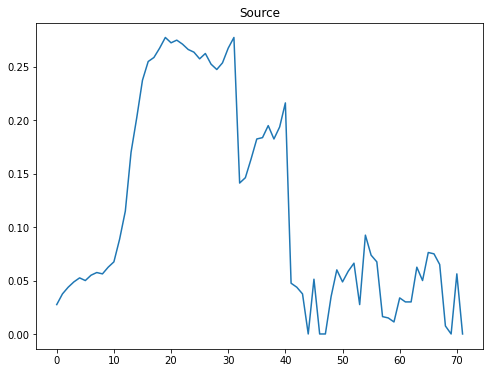

Time for epoch 1 is 157.10 sec
Time for epoch 2 is 150.49 sec
Time for epoch 3 is 150.98 sec
Time for epoch 4 is 150.84 sec
Time for epoch 5 is 150.78 sec
Time for epoch 6 is 150.89 sec
Time for epoch 7 is 151.01 sec
Time for epoch 8 is 151.24 sec
Time for epoch 9 is 151.29 sec
Time for epoch 10 is 151.15 sec
Time for epoch 11 is 150.84 sec
Time for epoch 12 is 150.69 sec
Time for epoch 13 is 150.83 sec
Time for epoch 14 is 151.00 sec
Time for epoch 15 is 151.07 sec
Time for epoch 16 is 151.12 sec
Time for epoch 17 is 151.03 sec
Time for epoch 18 is 150.65 sec
Time for epoch 19 is 150.54 sec
Time for epoch 20 is 150.62 sec
Time for epoch 21 is 150.79 sec
Time for epoch 22 is 150.69 sec
Time for epoch 23 is 150.95 sec
Time for epoch 24 is 150.75 sec
Time for epoch 25 is 151.07 sec
Time for epoch 26 is 150.98 sec
Time for epoch 27 is 150.96 sec
Time for epoch 28 is 150.95 sec
Time for epoch 29 is 150.87 sec
Time for epoch 30 is 150.64 sec
Time for epoch 31 is 151.01 sec
Time for epoch 32

In [ ]:
# main

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
"""load data"""
source_dict = sio.loadmat('/content/Source.mat')
source_train_ds, source_test_ds = gen_dataset_from_dict(source_dict)
target_dict = sio.loadmat('/content/Target.mat')
target_train_ds, target_test_ds, target_val_ds = gen_dataset_from_dict(target_dict, Val=True)

plt.plot(np.arange(72), source_train_ds.as_numpy_iterator().next()['data'][0, :, 0])
plt.title('Source')
plt.show()

generator = make_generator()
discriminator = make_discriminator()
classifier = make_classifier_model()
fit(source_train_ds, target_train_ds,
    generator, discriminator, classifier, EPOCHS)
val_accuracy = tf.keras.metrics.CategoricalAccuracy('val_accuracy')
acc = []
for val_batch in target_val_ds.as_numpy_iterator():
    x, y = get_data_from_batch(val_batch)
    prediction = classifier(x, training=False)
    val_accuracy(y, prediction)
    acc.append(val_accuracy.result()*100)
    template = 'average Accuracy: {:.2f}%'
    print(template.format(np.average(acc)))
